# Exploring data with CDF

## Background
Enspired by [Eric Ma](https://ericmjl.github.io/blog/2018/7/14/ecdfs/) I am describing how to analyize pandas Series from with bokeh and holoviews


## Intro to  

In [2]:
import numpy as np
import pandas as pd
from bokeh.sampledata.autompg import autompg
from bokeh.models import Range1d, LinearAxis
import holoviews as hv

hv.extension('bokeh')
autompg = autompg.set_index('name')
autompg.head()

ModuleNotFoundError: No module named 'holoviews'

In [31]:
def create_hist_cdf(df:pd.DataFrame, col: str, bins=10):
    np_out, np_bins = np.histogram(df[col], bins=bins)
    cdf = (np_out.cumsum() / np_out.sum()).round(3) 
    df = pd.DataFrame(data=list(zip(np_out, cdf)), index=np_bins[1:], columns=[f'{col}_val_in_bins', f'{col}_cdf'])
    df.index.name = f"{col}_bins"
    return df

df = create_hist_cdf(autompg, 'mpg', bins = 30)
# count, division = np.histogram(autompg.mpg)
# np_out, np_bins = np.histogram(autompg.mpg, bins=50)
# cdf = (np_out.cumsum() / np_out.sum()).round(3) 
# df = pd.DataFrame(data=list(zip(np_out, cdf)), index=np_bins[1:], columns=['values_in_bin', 'cdf'])
# df.index.name = "bins"
df.head()

,mpg_val_in_bins,mpg_cdf
mpg_bins,,
10.253333,3,0.008
11.506667,4,0.018
12.760000,6,0.033
14.013333,39,0.133
15.266667,17,0.176


In [21]:
def plot_secondary(plot, element):
    ''' 
    A hook to put data on secondary axis
    '''
    p = plot.state
    
    # create secondary range and axis
    if 'twiny' not in [t for t in p.extra_y_ranges]:
        # you need to manually recreate primary axis to avoid weird behavior if you are going to 
        # use secondary_axis in your plots. From what i know this also relates to the way axis
        # behave in bokeh and unfortunately cannot be modified from hv unless you are 
        # willing to rewrite quite a bit of code
#         p.y_range = Range1d(start=0, end=10)
        p.y_range.name = 'default'
        p.extra_y_ranges = {"twiny": Range1d(start=0, end=10)}
        p.add_layout(LinearAxis(y_range_name="twiny"), 'right')

    # set glyph y_range_name to the one we've just created
    glyph = p.renderers[-1]
    glyph.y_range_name = 'twiny'

    # set proper range
    glyph = p.renderers[-1]
    vals = glyph.data_source.data['y'] # ugly hardcoded solution, see notes below
    p.extra_y_ranges["twiny"].start = vals.min()* 0.99
    p.extra_y_ranges["twiny"].end = vals.max()* 1.01

In [41]:
def get_overlay(df, col_vals, col_cumsum, label):    
    cdf = hv.Curve((df.index, df[col_cumsum]), label=col_cumsum)
    hist = hv.Histogram((df.index, df[col_vals].tolist()), label=col_vals, kdims=[df.index.name], vdims=[col_vals])

    primary = hist.opts(width=600, color='grey',  )    
    secondary = cdf.opts(width=600, color='red', show_grid=True, framewise=True, hooks=[plot_secondary])
    return primary * secondary 

# get_overlay(df, "mpg_val_in_bins", "mpg_cdf", "asdfsadf")

In [42]:
for col in autompg.columns:
    df = create_hist_cdf(autompg, col, bins = 30)
    col_val_bin = [col for col in df.columns if col.endswith('bins')][0]
    col_cdf = [col for col in df.columns if col.endswith('cdf')][0]      
    display(get_overlay(df, col_val_bin, col_cdf, "asdfsadf"))

:Overlay
   .Histogram.Mpg_val_in_bins :Histogram   [mpg_bins]   (mpg_val_in_bins)
   .Curve.Mpg_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Cyl_val_in_bins :Histogram   [cyl_bins]   (cyl_val_in_bins)
   .Curve.Cyl_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Displ_val_in_bins :Histogram   [displ_bins]   (displ_val_in_bins)
   .Curve.Displ_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Hp_val_in_bins :Histogram   [hp_bins]   (hp_val_in_bins)
   .Curve.Hp_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Weight_val_in_bins :Histogram   [weight_bins]   (weight_val_in_bins)
   .Curve.Weight_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Accel_val_in_bins :Histogram   [accel_bins]   (accel_val_in_bins)
   .Curve.Accel_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Yr_val_in_bins :Histogram   [yr_bins]   (yr_val_in_bins)
   .Curve.Yr_cdf             :Curve   [x]   (y)

:Overlay
   .Histogram.Origin_val_in_bins :Histogram   [origin_bins]   (origin_val_in_bins)
   .Curve.Origin_cdf             :Curve   [x]   (y)

<AxesSubplot:>

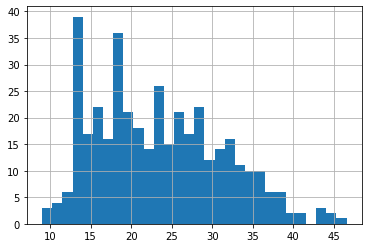

In [60]:
autompg.mpg.hist(bins=30)